In [1]:
import pandas as pd
from tqdm import tqdm
from collections import Counter
import string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score,f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def preprocess_sentence(text):
    # convert to lowercase
    text = text.lower()

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # tokenize the text
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # stem the words
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return stemmed_tokens

In [68]:
cves = pd.read_csv('data/raw_cves.csv', usecols=["cve.descriptions.lang.en","cve.metrics.cvssMetricV31.cvssData.attackVector","cve.metrics.cvssMetricV31"])
v31 = cves[cves['cve.metrics.cvssMetricV31']==True].drop("cve.metrics.cvssMetricV31",axis=1)
v31['tokens'] = v31["cve.descriptions.lang.en"].apply(lambda x: preprocess_sentence(x))
v31.reset_index(inplace=True)
print(v31.shape)

C:\Users\elyes\AppData\Local\Temp\ipykernel_11168\2987698934.py:1: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  cves = pd.read_csv('data/raw_cves.csv', usecols=["cve.descriptions.lang.en","cve.metrics.cvssMetricV31.cvssData.attackVector","cve.metrics.cvssMetricV31"])


(81889, 4)


In [88]:
pd.read_csv('data/raw_cves.csv').iloc[0].values

C:\Users\elyes\AppData\Local\Temp\ipykernel_11168\1947772980.py:1: DtypeWarning: Columns (13,19,20,21,22,23,40,41,44,45,46,47,48,52,53,54,55,56,57,58,59,60,62,63,84) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('data/raw_cves.csv').iloc[0].values


array(['CVE-1999-0095', 'cve@mitre.org', '1988-10-01T04:00:00.000',
       '2019-06-11T20:29:00.263', 'Modified',
       "[{'source': 'nvd@nist.gov', 'type': 'Primary', 'description': [{'lang': 'en', 'value': 'NVD-CWE-Other'}]}]",
       False, False, nan, nan, nan, nan,
       'The debug command in Sendmail is enabled, allowing attackers to execute commands as root.',
       'El comando de depuración de Sendmail está activado, permitiendo a atacantes ejecutar comandos como root.',
       'nvd@nist.gov', 'Primary', 'HIGH', 10.0, 10.0, False, True, False,
       False, False, 2.0, 'AV:N/AC:L/Au:N/C:C/I:C/A:C', 'NETWORK', 'LOW',
       'NONE', 'COMPLETE', 'COMPLETE', 'COMPLETE', 10.0,
       'http://seclists.org/fulldisclosure/2019/Jun/16', 'cve@mitre.org',
       'http://www.openwall.com/lists/oss-security/2019/06/05/4',
       'cve@mitre.org',
       'http://www.openwall.com/lists/oss-security/2019/06/06/1',
       'cve@mitre.org', 'OR', False, True,
       'cpe:2.3:a:eric_allman:sendm

In [ ]:
# make a dictionary where keys are the tokens and values are the classes they appear in.
# We will only take words that appeared in a single class afterwards

word_class = {}

for i,row in tqdm(v31.iterrows()):
    label = row["cve.metrics.cvssMetricV31.cvssData.attackVector"]
    for token in row['tokens']:
        if token in word_class.keys():
            word_class[token].append(label)
        else:
            word_class[token] = [label]

print(len(word_class))

In [ ]:
# make new dictionnary where only words that appeared in a single class remain
d = {k: [i for i in v if len(v)==1] for k,v in word_class.items()}
exclusive_words = {k:v[0] for k,v in d.items() if v}

# example from the data
# {'scriptalia': 'NETWORK', 'hamradio6packc': 'LOCAL' 'bblog': 'NETWORK'}
len(exclusive_words)

In [ ]:
exclusive_found = {}
v31['classes'] = ""
for i,row in tqdm(v31.iterrows()):
    for token in row['tokens']:
        if token in exclusive_words.keys():
            v31.at[i,'classes'] += exclusive_words[token] + ','
            exclusive_found[token] = 0

In [74]:
v31

,index,cve.descriptions.lang.en,cve.metrics.cvssMetricV31.cvssData.attackVector,classes,tokens
0,194,ScriptAlias directory in NCSA and Apache httpd...,NETWORK,"NETWORK,NETWORK,","[scriptalia, directori, ncsa, apach, httpd, al..."
1,8217,Cross-site scripting (XSS) vulnerability in th...,NETWORK,"NETWORK,NETWORK,","[crosssit, script, xss, vulner, administr, pan..."
2,31380,"The DNS protocol, as implemented in (1) BIND 8...",NETWORK,"NETWORK,NETWORK,NETWORK,NETWORK,NETWORK,","[dn, protocol, implement, 1, bind, 8, 9, 950p1..."
3,31393,The Linux kernel before 2.6.25.10 does not pro...,LOCAL,"LOCAL,LOCAL,LOCAL,LOCAL,LOCAL,LOCAL,LOCAL,LOCA...","[linux, kernel, 262510, properli, perform, tti..."
4,31401,The do_change_type function in fs/namespace.c ...,LOCAL,"LOCAL,","[dochangetyp, function, fsnamespacec, linux, k..."
...,...,...,...,...,...
81884,197728,savg-sanitizer is a PHP SVG/XML Sanitizer. A b...,NETWORK,"NETWORK,NETWORK,NETWORK,NETWORK,","[savgsanit, php, svgxml, sanit, bypass, found,..."
81885,197730,PDFio is a C library for reading and writing P...,LOCAL,"LOCAL,","[pdfio, c, librari, read, write, pdf, file, ve..."
81886,197731,Pimcore is an open source data and experience ...,NETWORK,"NETWORK,","[pimcor, open, sourc, data, experi, manag, pla..."
81887,197753,HTML Email Injection in Tribe29 Checkmk <=2.1....,NETWORK,"NETWORK,NETWORK,","[html, email, inject, tribe29, checkmk, 210p23..."


In [130]:
# what percentage of the dataset has exclusive words
print(round(len(v31[v31['classes'] != ""])/len(v31) * 100,10)) # 46.67%
contain_exclusive = v31[v31['classes'] != ""]

46.6692718192


In [131]:
len(contain_exclusive)

38217

In [136]:
# check if all classes are unanimous
count = 0
for l in contain_exclusive['classes'].str.split(',').values:
    count += len(set(l[:-1]))
count

38217

In [142]:
contain_exclusive['predicted'] = contain_exclusive['classes'].apply( lambda x: str(set(x.split(',')[:-1]).pop())) 
contain_exclusive[['cve.metrics.cvssMetricV31.cvssData.attackVector','predicted']]                                                              

C:\Users\elyes\AppData\Local\Temp\ipykernel_12340\2210055518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contain_exclusive['predicted'] = contain_exclusive['classes'].apply( lambda x: str(set(x.split(',')[:-1]).pop()))


,cve.metrics.cvssMetricV31.cvssData.attackVector,predicted
0,NETWORK,NETWORK
1,NETWORK,NETWORK
2,NETWORK,NETWORK
3,LOCAL,LOCAL
4,LOCAL,LOCAL
...,...,...
81883,NETWORK,NETWORK
81884,NETWORK,NETWORK
81885,LOCAL,LOCAL
81886,NETWORK,NETWORK


In [144]:
y_true = contain_exclusive['cve.metrics.cvssMetricV31.cvssData.attackVector']    
y_preds = contain_exclusive['predicted']

print("Accuracy: ", accuracy_score(y_preds,y_true))
print('F1: ', f1_score(y_preds,y_true,average="weighted"))

Accuracy:  1.0
F1:  1.0


In [4]:
# tokenize then preprocess all the words, will be used to count frequencies
full_text = " ".join(v31["cve.descriptions.lang.en"].values)
full_tokens = preprocess_sentence(full_text)

In [5]:
count = Counter(full_tokens)

In [6]:
count_counter = {}
for k,v in count.items():
    if v in count_counter.keys():
        count_counter[v] += 1
    else:
        count_counter[v] = 1

In [156]:
Counter(full_tokens).most_common()[:10]

[('vulner', 64706),
 ('attack', 51580),
 ('allow', 37937),
 ('version', 36899),
 ('user', 29445),
 ('execut', 22729),
 ('could', 21971),
 ('affect', 21071),
 ('via', 20474),
 ('access', 20194)]

In [154]:
Counter(full_tokens).most_common()[-10:]

[('httpspackagesgentooorg', 1),
 ('4fa6e4b619c0362728955b6ec56eab0e0cbf1e23i', 1),
 ('savgsanit', 1),
 ('textnod', 1),
 ('htmlpurifi', 1),
 ('foriegnobject', 1),
 ('cve202324808', 1),
 ('dataobject', 1),
 ('210p23', 1),
 ('200p34', 1)]

In [26]:
Counter(full_tokens)

Counter({'scriptalia': 1,
         'directori': 2754,
         'ncsa': 1,
         'apach': 1107,
         'httpd': 100,
         'allow': 37937,
         'attack': 51580,
         'read': 5909,
         'cgi': 119,
         'program': 831,
         'crosssit': 6594,
         'script': 10107,
         'xss': 7255,
         'vulner': 64706,
         'administr': 3499,
         'panel': 555,
         'bblog': 1,
         '072': 27,
         'remot': 17687,
         'authent': 11014,
         'user': 29445,
         'superus': 46,
         'privileg': 16558,
         'inject': 10131,
         'arbitrari': 15273,
         'web': 6665,
         'html': 3100,
         'via': 20474,
         'blog': 167,
         'name': 3006,
         'blognam': 1,
         'note': 2228,
         'normal': 394,
         'add': 700,
         'mean': 279,
         'eg': 896,
         'smarti': 12,
         'templat': 632,
         'issu': 18546,
         'would': 2113,
         'give': 185,
         'addit': 2

In [35]:
Counter(list(count.values()))

Counter({1: 67893,
         2754: 1,
         1107: 1,
         100: 14,
         37937: 1,
         51580: 1,
         5909: 1,
         119: 13,
         831: 2,
         6594: 1,
         10107: 1,
         7255: 1,
         64706: 1,
         3499: 1,
         555: 1,
         27: 133,
         17687: 1,
         11014: 1,
         29445: 1,
         46: 52,
         16558: 1,
         10131: 1,
         15273: 1,
         6665: 1,
         3100: 1,
         20474: 1,
         167: 7,
         3006: 1,
         2228: 1,
         394: 4,
         700: 1,
         279: 5,
         896: 2,
         12: 553,
         632: 3,
         18546: 1,
         2113: 1,
         185: 5,
         2899: 1,
         821: 1,
         244: 1,
         559: 2,
         2115: 1,
         1841: 1,
         1156: 1,
         261: 5,
         333: 4,
         480: 1,
         1087: 1,
         1680: 1,
         5376: 1,
         10: 784,
         19: 224,
         146: 13,
         35: 102,
         1213

array([[<Axes: title={'center': 'count'}>]], dtype=object)

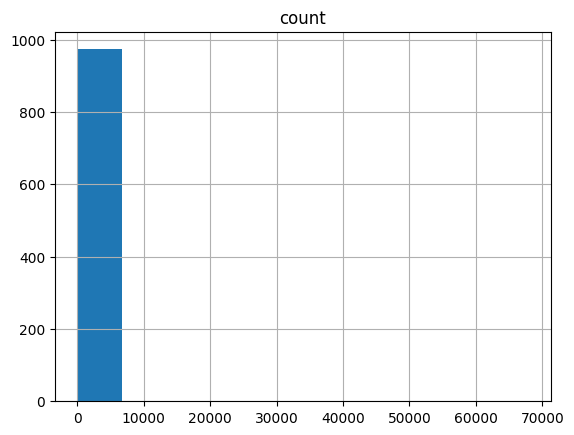

In [67]:
d = sorted(Counter(list(count.values())).items(), key=lambda item: item[1])
d = pd.DataFrame.from_dict(d)
d.rename(columns={0:"occurences",1:"count"}, inplace=True)
d.set_index('occurences', inplace=True)
d.hist(bins=10)

In [30]:
d = sorted(Counter(list(count.values())).items(), key=lambda item: item[1])
plt.plot(d.keys(), d.values())

AttributeError: 'list' object has no attribute 'keys'